

## Instead.. look at the the damped least squares notebook from brad and use the implicit solver (heat package on github).
1) monte carlo for perturb temperature series.

## Get this working on one borehole first and then the others after

# Import packages

In [490]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from heat import heat
import pickle
from tqdm import tqdm
import multiprocessing as mp
from sklearn.metrics import mean_absolute_error
import copy
from DTS_processing_functions import *
import emcee
import corner

# Functions

In [411]:


def likelihood(m,A_jk,anomaly,sigma):
#     print(A_jk.shape)
#     print(m.shape)
    predicted_data = A_jk @ m
    mae = mean_absolute_error(anomaly,predicted_data)
    return np.exp(-mae**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 

def mcmc_step(m_old,L_old,sigma,A_jk,anomaly):
    nt=len(m_old)
    m_old = copy.deepcopy(m_old)
    year_change = np.random.randint(0,m_old.shape[0]) #randomly select a year to change

    m = m_old
    m[year_change] = m[year_change] + np.random.normal(loc=0,scale=0.5)
#     m = m_old + brown_noise(len(m_old), alpha=0.01)
    L = likelihood(m,A_jk,anomaly,sigma)
    alpha = np.random.rand()

    if L0-L <= alpha:
        return m,L
    
    return [0],[0]

def steadystate(z, dTdz, tsurf_avg):
    return tsurf_avg+dTdz*z

# Function to organize the Greens Function
def get_G(time_step, tsurf_avg = -31, number_of_time_steps = 99):
    
    delta = tsurf_avg*np.ones(number_of_time_steps)
    delta[time_step] =  1

    U,t,z = heat(delta,tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=dTdz,nz=(nz-1))
    return U[:,-1]

# Load data

In [412]:
filepath = '/data/fast1/jm-scratch/data_proc.pkl'

downsample = 10

with open(filepath,'rb') as file:
    data = pickle.load(file)
real_data = data['ALHIC1902_23_5min']

z_full = np.array(real_data[0])
z_real = z_full[::downsample]
T_full = np.array(real_data[2])
T_real = T_full[::downsample]


T_surf = real_data[7]

max_depth = max(z_real)
nz = len(z_real)

dTdz = 0.02

# Create the G matrix

In [413]:
start_year = 1823
end_year = 2023
number_of_time_steps = 399
t = np.linspace(start_year,end_year, number_of_time_steps+1)

G = np.zeros((nz,number_of_time_steps))
for i in tqdm(range(number_of_time_steps)): 
    G[:,i] = get_G(i, tsurf_avg = T_surf, number_of_time_steps = number_of_time_steps) #- steadystate(z_real)
G = G[:,1:]

100%|██████████| 399/399 [02:25<00:00,  2.74it/s]


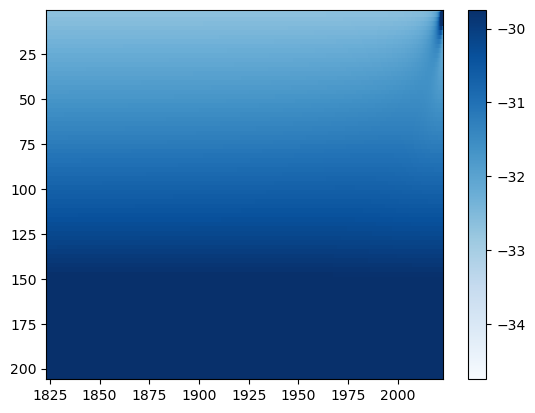

In [414]:
c=plt.pcolormesh(t[1:-1],z_real,G,vmin=T_surf-2,vmax=T_surf+3,cmap='Blues')
plt.colorbar(c)
plt.ylim([z_real[-1],z_real[0]])
plt.show()

# Do the inversion

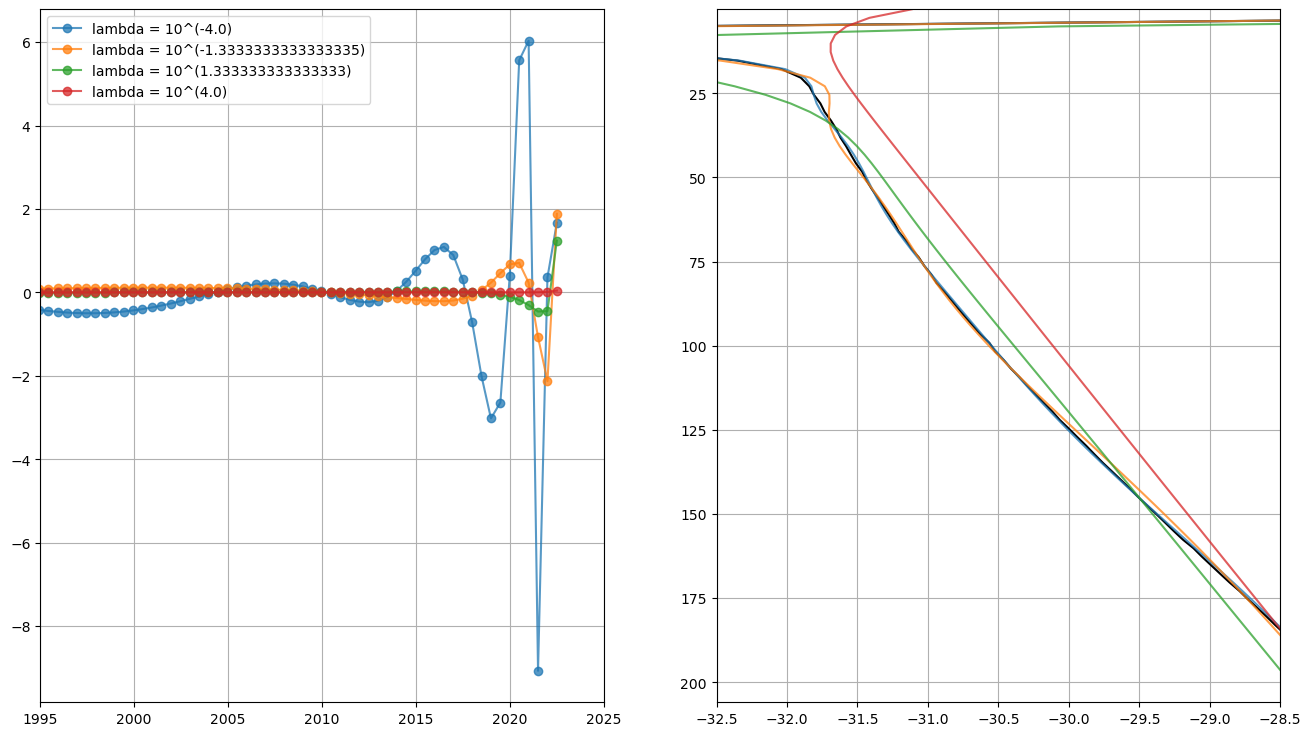

In [415]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(-4,4,4): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(t[1:-1],x_damped,'-o',
               label=f'lambda = 10^({np.log10(lmbda)})',alpha=0.75)

    T_fit = np.matmul(G,x_damped)
    ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
ax[1].set_xlim([-32.5,-28.5])
ax[0].grid()
ax[1].grid()
ax[0].set_xlim([1995,2025])
ax[0].legend()

# plt.plot(t[1:-1],synthetic_history,'--k')

### What if we modulated the dampening factor?

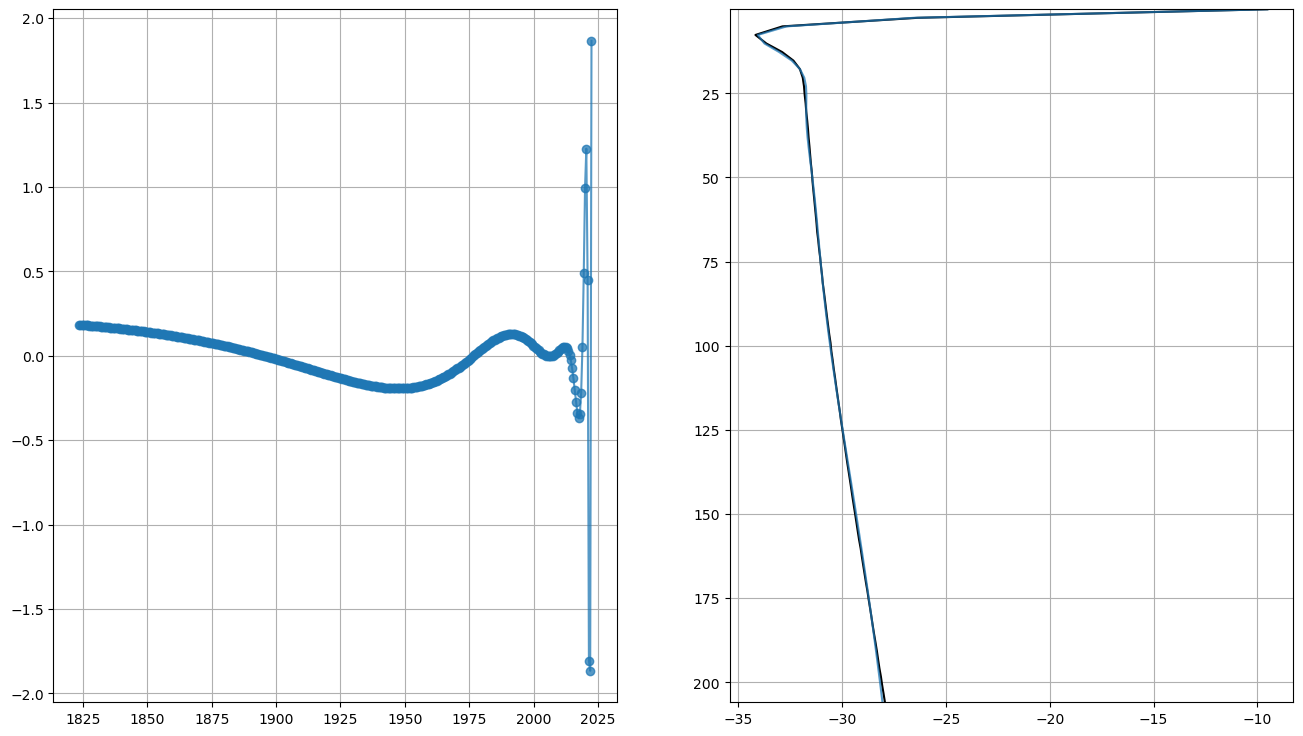

In [416]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')

lmbda = np.logspace(2,-2,G.shape[1])[-1]

# Formulate the regularized least squares problem
# We need to augment A with the regularization term
A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
b_augmented = np.concatenate([T_real, np.zeros(G.shape[1])])

# Solve the regularized least squares problem
x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
ax[0].plot(t[1:-1],x_damped,'-o',alpha=0.75)

T_fit = np.matmul(G,x_damped)
ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
# ax[1].set_xlim([-32.5,-28.5])
ax[0].grid()
ax[1].grid()
# ax[0].set_xlim([1995,2025])


# What if we cut the top off of G

In [454]:
cutoff = 10
G_bot = G[cutoff:,:]

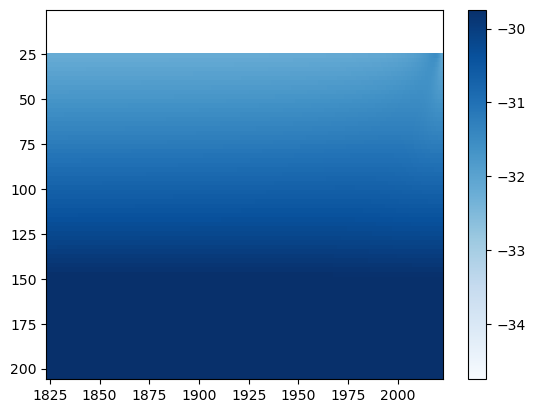

In [455]:
c=plt.pcolormesh(t[1:-1],z_real[cutoff:],G_bot,vmin=T_surf-2,vmax=T_surf+3,cmap='Blues')
plt.colorbar(c)
plt.ylim([z_real[-1],z_real[0]])
plt.show()

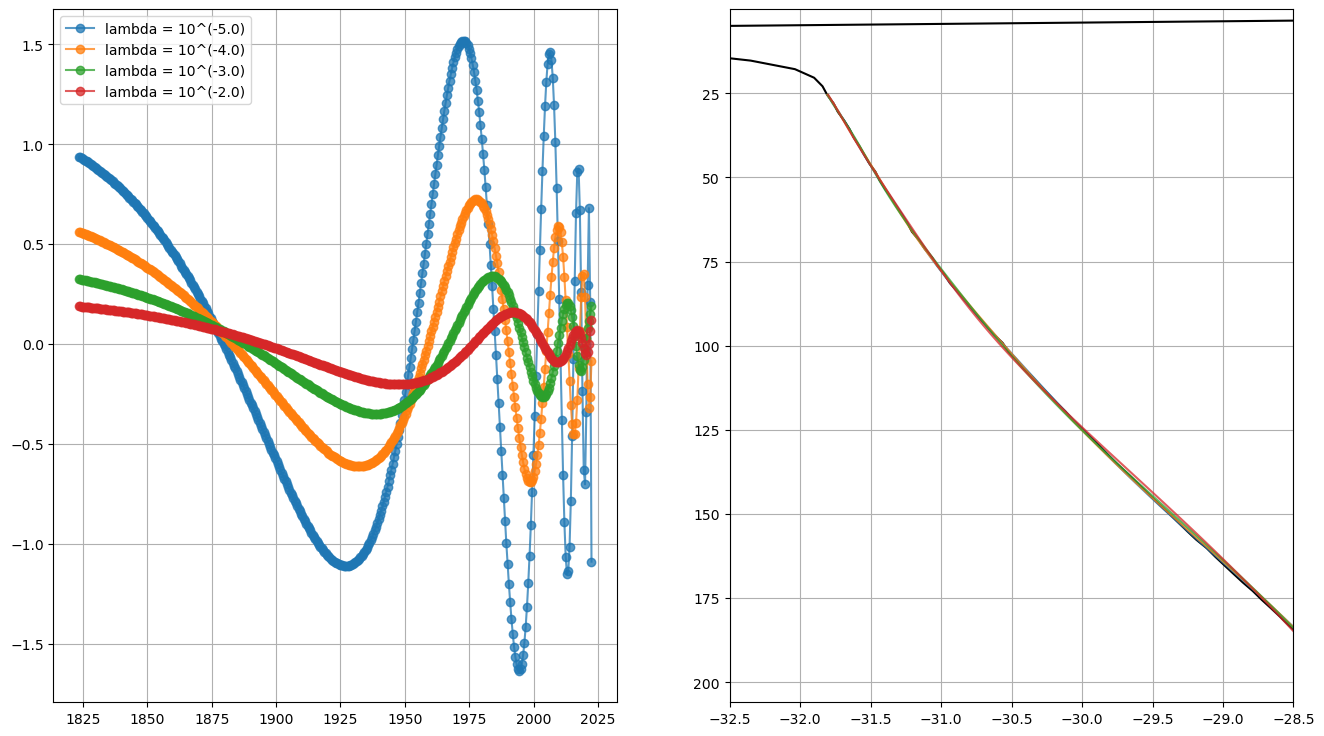

In [464]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(-5,-2,4): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G_bot, np.sqrt(lmbda) * np.eye(G_bot.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state[cutoff:], np.zeros(G_bot.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(t[1:-1],x_damped,'-o',
               label=f'lambda = 10^({np.log10(lmbda)})',alpha=0.75)

    T_fit = np.matmul(G_bot,x_damped)
    ax[1].plot(T_fit,z_real[cutoff:],alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
ax[1].set_xlim([-32.5,-28.5])
ax[0].grid()
ax[1].grid()
# ax[0].set_xlim([1995,2025])
ax[0].legend()


In [493]:
y = T_real
yerr = [0.01] * len(y)

In [576]:
def log_likelihood(theta, y, yerr):
    model = G @ theta
    sigma2 = 0.1**2 + model**2 * np.exp(2 * 0.1)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):

    return 0.0

def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)

In [659]:
import emcee

pos = x_damped  + 1e-2 * np.random.randn(32, len(x_damped))
# pos = np.ones(len(x_damped)) + 1e-4 * np.random.randn(32, len(x_damped))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, moves=emcee.moves.GaussianMove(.01), args=(y, yerr), 
)
sampler.run_mcmc(pos, 1000, progress=True, skip_initial_state_check=True);

100%|██████████| 1000/1000 [00:01<00:00, 754.81it/s]


In [660]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(1920, 398)


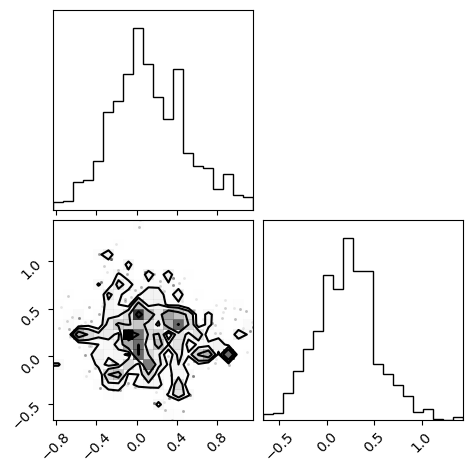

In [661]:
fig = corner.corner(
    flat_samples[:,:2]
);

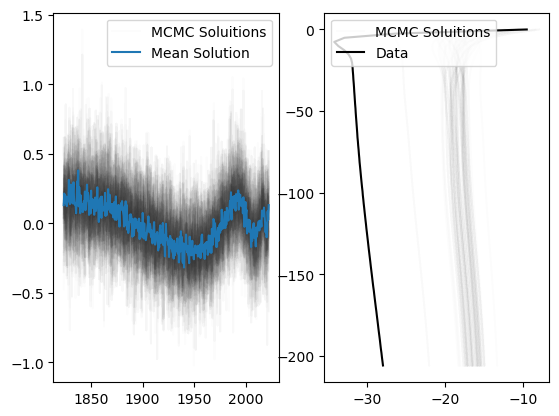

In [670]:
fig,ax = plt.subplots(1,2)

MCMC_sol = ax[0].plot(t[1:-1],flat_samples.T[:,0:100],c='black',alpha=0.01, label='MCMC Soluitions')
MCMC_mean = ax[0].plot(t[1:-1],np.mean(flat_samples,axis=0), label='Mean Solution')
ax[0].legend(handles=[MCMC_sol[0], MCMC_mean[0]], labels=['MCMC Soluitions', 'Mean Solution'])

for_MCMC = ax[1].plot(np.matmul(G,flat_samples.T[:,0:100]),z_real*-1,c='black',alpha=0.01, label='Forward MCMC')
data_plot = ax[1].plot(T_real,z_real*-1,c='black', label='Data')
ax[1].legend(handles=[for_MCMC[0], data_plot[0]], labels=['MCMC Soluitions', 'Data'])

plt.show()